In [1]:
# Let's import the required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from collections import Counter

import warnings 
warnings.filterwarnings('ignore')

# Data Acquisition

In [2]:

df=pd.read_csv('train_news.csv')
df

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1
...,...,...,...,...,...,...
20795,20795,5671,NaN,NeverSurrender,"No, you'll be a dog licking of the vomit of yo...",1
20796,20796,14831,Albert Pike and the European Migrant Crisis,Rixon Stewart,"By Rixon Stewart on November 5, 2016 Rixon Ste...",1
20797,20797,18142,Dakota Access Caught Infiltrating Protests to ...,Eddy Lavine,posted by Eddie You know the Dakota Access Pip...,1
20798,20798,12139,How to Stretch the Summer Solstice - The New Y...,Alison S. Cohn,"It’s officially summer, and the Society Boutiq...",0


In [3]:
#checking features name
print("Features/Columns :\n", df.columns)

Features/Columns :
 Index(['Unnamed: 0', 'id', 'headline', 'written_by', 'news', 'label'], dtype='object')


In [4]:
#checking shape of train dataset
print ('Shape =',df.shape)

Shape = (20800, 6)


In [5]:
#checking datatype of each feature
print("Data Types :\n", df.dtypes)

Data Types :
 Unnamed: 0     int64
id             int64
headline      object
written_by    object
news          object
label          int64
dtype: object


In [6]:
#checking NAN value
print("Contains NaN/Empty cells : ", df.isnull().values.any())

Contains NaN/Empty cells :  True


- It means that null values are present in the given dataset

In [7]:
# Let's see how many Null Values are present in each column
print(df.isnull().sum())

Unnamed: 0       0
id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64


<AxesSubplot:>

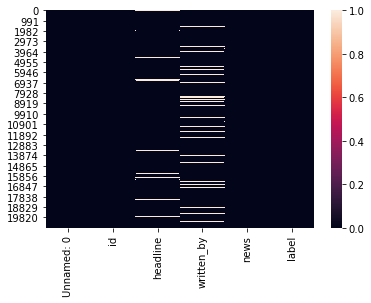

In [8]:
sns.heatmap(df.isnull())

In [9]:
# Let's drop Unnamed: 0  & id from dataset as it does not seem important
df.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [36]:
df.reset_index(inplace=True)

In [10]:
# Feature subject is having some null values, in here I am 
# filling 'Written_by' feature with unknown because sometimes there are anonymus authors,...
# filling up empty values in 'headline'  with 'No Headline'
# Dropping empty values in rows because we are detecting fake news here and for this news is needed..

df['written_by'].fillna('Unknown ',inplace=True)
df['headline'].fillna('no headlines ',inplace=True)
df.dropna(subset=['news'],inplace=True)
df.head()

,headline,written_by,news,label
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


<AxesSubplot:>

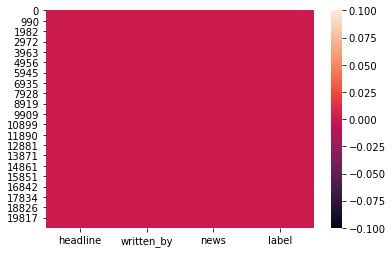

In [11]:
# Hetmap for null values
sns.heatmap(df.isnull())

In [12]:
#Ratio
print ('Fake = ', round(len(df[df['label']==1]) / len(df.label),2)*100,'%')
print ('Not Fake  = ', round(len(df[df['label']==0]) / len(df.label),2)*100,'%')

Fake =  50.0 %
Not Fake  =  50.0 %


In [13]:
# Checking how many distinct writers are there
df['written_by'].value_counts()

Unknown                               1918
Pam Key                                243
admin                                  193
Jerome Hudson                          166
Charlie Spiering                       141
                                      ... 
Naomi Klein                              1
Dexy                                     1
Saeed Al-Batati                          1
Bettie                                   1
Katie Thomas and Matthew Goldstein       1
Name: written_by, Length: 4202, dtype: int64

In [14]:
#New columns for headline, author and news of message and subject
df['length_headline'] = df.headline.str.len()
#df['length_written_by'] = df.written_by.str.len()
df['length_news'] = df.news.str.len()
df.head()

,headline,written_by,news,label,length_headline,length_news
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,84,7936
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,72,6112
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,100,425
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,100,6516
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,28,9164


In [15]:
df['headline'] = df.headline.str.lower()
df['written_by'] = df.written_by.str.lower()
df['news'] = df.news.str.lower()

In [16]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [17]:
# function to filter using POS tagging. This will be called inside the below function
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning.
def Processed_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [18]:
df['clean_headline']=df['headline'].apply(Processed_data)

In [19]:
df['clean_news']=df['news'].apply(Processed_data)

In [20]:
df.head()

,headline,written_by,news,label,length_headline,length_news,clean_headline,clean_news
0,ethics questions dogged agriculture nominee as...,eric lipton and steve eder,"washington — in sonny perdue’s telling, geo...",0,84,7936,ethic question dogged agriculture nominee geor...,washington sonny perdue telling georgian growi...
1,u.s. must dig deep to stop argentina’s lionel ...,david waldstein,houston — venezuela had a plan. it was a ta...,0,72,6112,deep stop argentina lionel messi york time,houston venezuela plan tactical approach desig...
2,cotton to house: ’do not walk the plank and vo...,pam key,"sunday on abc’s “this week,” while discussing ...",0,100,425,cotton house walk plank vote senate breitbart,sunday week discussing republican plan repeal ...
3,"paul lepage, besieged maine governor, sends co...",jess bidgood,"augusta, me. — the beleaguered republican g...",0,100,6516,paul lepage besieged maine governor sends conf...,augusta beleaguered republican governor maine ...
4,a digital 9/11 if trump wins,finian cunningham,finian cunningham has written extensively on...,1,28,9164,digital trump,finian cunningham written extensively internat...


from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer(r'\w+')
df['headline'] = df['headline'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['written_by'] = df['written_by'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['news'] = df['news'].apply(lambda x: tokenizer.tokenize(x.lower()))
df.head()

In [21]:
#df['headline'] = df['clean_headline'].apply(lambda x:' '.join(y for y in x))
#df['written_by'] = df['written_by'].apply(lambda x:' '.join(y for y in x))
#df['news'] = df['clean_news'].apply(lambda x:' '.join(y for y in x))
df['clean_length_headline']=df.clean_headline.str.len()
df['clean_length_news']=df.clean_news.str.len()

df.head(10)

,headline,written_by,news,label,length_headline,length_news,clean_headline,clean_news,clean_length_headline,clean_length_news
0,ethics questions dogged agriculture nominee as...,eric lipton and steve eder,"washington — in sonny perdue’s telling, geo...",0,84,7936,ethic question dogged agriculture nominee geor...,washington sonny perdue telling georgian growi...,68,4803
1,u.s. must dig deep to stop argentina’s lionel ...,david waldstein,houston — venezuela had a plan. it was a ta...,0,72,6112,deep stop argentina lionel messi york time,houston venezuela plan tactical approach desig...,42,3632
2,cotton to house: ’do not walk the plank and vo...,pam key,"sunday on abc’s “this week,” while discussing ...",0,100,425,cotton house walk plank vote senate breitbart,sunday week discussing republican plan repeal ...,45,212
3,"paul lepage, besieged maine governor, sends co...",jess bidgood,"augusta, me. — the beleaguered republican g...",0,100,6516,paul lepage besieged maine governor sends conf...,augusta beleaguered republican governor maine ...,80,3847
4,a digital 9/11 if trump wins,finian cunningham,finian cunningham has written extensively on...,1,28,9164,digital trump,finian cunningham written extensively internat...,13,5888
5,whatever the outcome on november 8th the us wi...,unknown,taming the corporate media beast whatever the ...,1,106,15285,outcome november collision course china federi...,taming corporate medium beast outcome november...,59,9223
6,rapid evolution saved this fish from pollution...,joanna klein,the state of new jersey says you can’t eat the...,0,79,4159,rapid evolution saved fish pollution study yor...,state jersey fish shellfish passaic river newa...,52,2473
7,alabama prison officials retaliate against pri...,brian sonenstein,advocates say prison officials at the kilby co...,1,88,6311,alabama prison official retaliate prison strik...,advocate prison official kilby correctional fa...,73,3494
8,no headlines,steventexas,people have made up their minds on president.\...,1,13,782,headline,people mind president served elected district ...,8,449
9,can we live in a constant state of love?,gillian,leave a reply \ntoni emerson – when we fall in...,1,40,6386,live constant state love,leave reply toni emerson fall love heart feel ...,24,3760


In [61]:
df['comment_text']=lemmatize_stemming(df['headline'])
df.head()

UnboundLocalError: local variable 'stemmed_content' referenced before assignment

In [22]:
# Total length removal
print ('Origian Length', df.length_headline.sum())
print ('Clean Length', df.clean_length_headline.sum())
print('Total Reduction = ',df['length_headline'].sum()-df['clean_length_headline'].sum())

Origian Length 1507844
Clean Length 1040606
Total Reduction =  467238


In [23]:
# Total length removal
print ('Origian Length', df.length_news.sum())
print ('Clean Length', df.clean_length_news.sum())
print('Total Reduction = ',df['length_news'].sum()-df['clean_length_news'].sum())

Origian Length 94518924
Clean Length 56207800
Total Reduction =  38311124


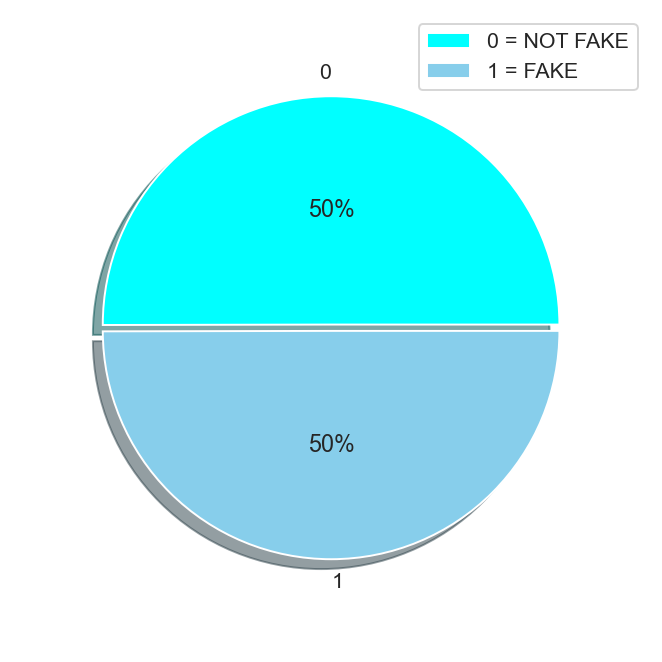

In [24]:
lb=df['label'].value_counts().index.tolist()
val=df['label'].value_counts().values.tolist()
exp=(0.025,0)
clr=('cyan','skyblue')
plt.figure(figsize=(10,6),dpi=140)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=val,explode=exp,labels=lb,colors=clr,autopct='%2.0f%%',pctdistance=0.5, shadow=True,radius=0.9)
plt.legend(["0 = NOT FAKE",'1 = FAKE'])
plt.show()

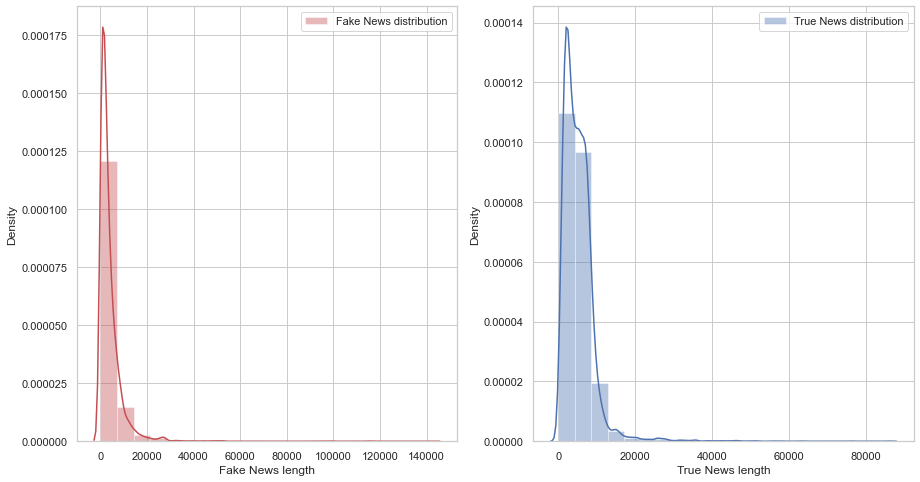

In [25]:
# news distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df[df['label']==1]['length_news'],bins=20,ax=ax[0],label='Fake News distribution',color='r')

ax[0].set_xlabel('Fake News length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length_news'],bins=20,ax=ax[1],label='True News distribution')
ax[1].set_xlabel('True News length')
ax[1].legend()

plt.show()

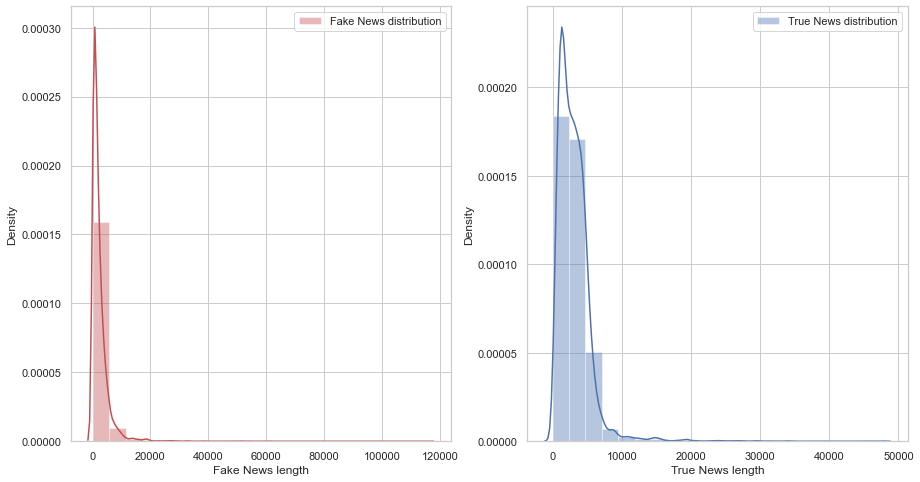

In [26]:
# news distribution AFTER cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df[df['label']==1]['clean_length_news'],bins=20,ax=ax[0],label='Fake News distribution',color='r')

ax[0].set_xlabel('Fake News length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length_news'],bins=20,ax=ax[1],label='True News distribution')
ax[1].set_xlabel('True News length')
ax[1].legend()

plt.show()

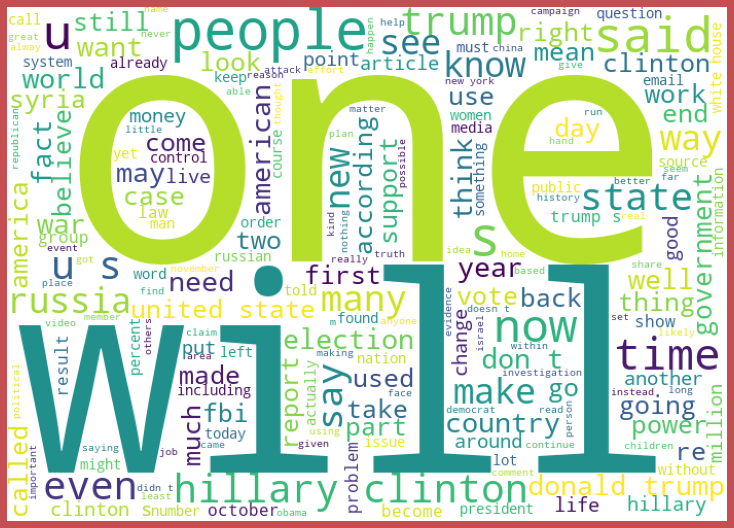

In [27]:
#Getting sense of loud words in Fake News - Articles
from wordcloud import WordCloud

fake = df['news'][df['label']==1]

fake_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(fake))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(fake_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

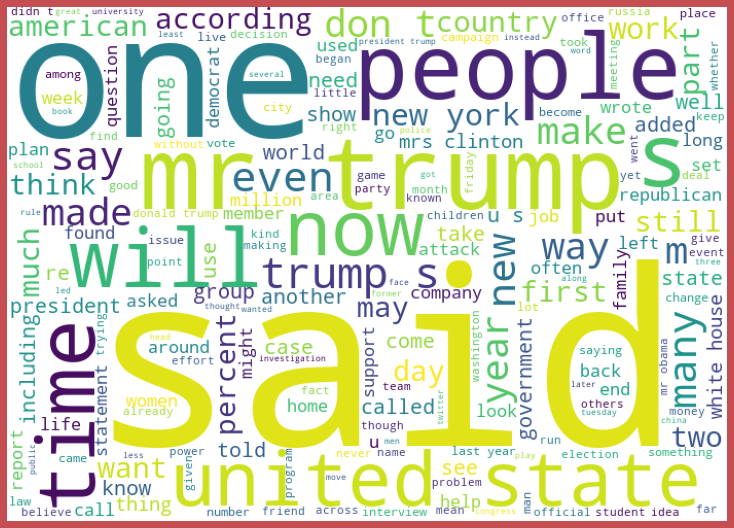

In [28]:
#Getting sense of loud words in Not Fake News - Articles
from wordcloud import WordCloud

not_fake = df['news'][df['label']==0]

not_fake_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(not_fake))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(not_fake_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

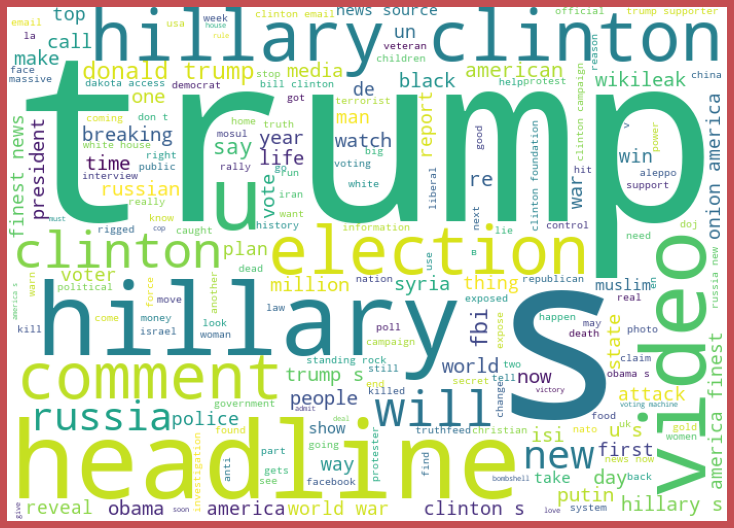

In [29]:
#Getting sense of loud words in Fake News - Headline
from wordcloud import WordCloud

fake = df['headline'][df['label']==1]

fake_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(fake))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(fake_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

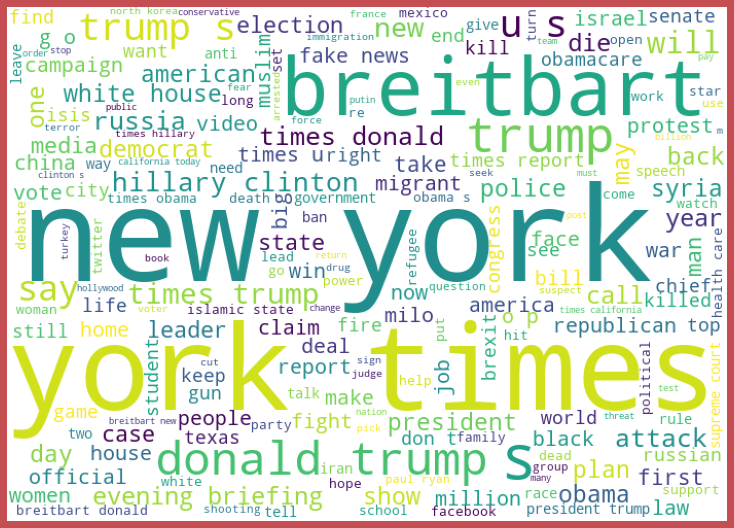

In [30]:
#Getting sense of loud words in Not Fake News - Headline
from wordcloud import WordCloud

not_fake = df['headline'][df['label']==0]

not_fake_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(not_fake))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(not_fake_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [31]:
from nltk import tokenize
import seaborn as sns
import numpy as np
# Most Frequent Words in Fake and Real News
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency")
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

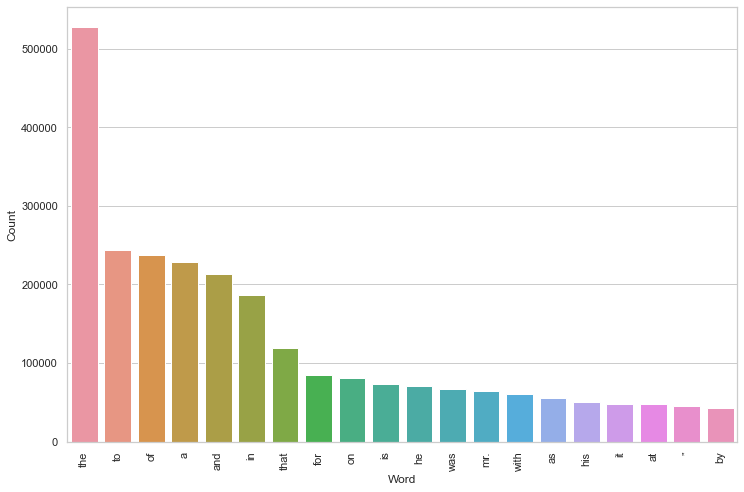

In [32]:
counter(df[df["label"] == 0], "news", 20)

In [37]:
from collections import Counter
#for counting frequently occurence of Negative and Non negative words.
count1 = Counter(" ".join(df[df['label']==1]["clean_headline"]).split()).most_common(50)
count2 = Counter(" ".join(df[df['label']==0]["clean_headline"]).split()).most_common(50)
dataframe=pd.DataFrame()
print("TOP 50 Words in Each Category (Word,Counts)")
dataframe['Most Frequent Words in Negative Comments']=count1
dataframe['Most Frequent Words in Non negative Comments']=count2
dataframe

TOP 50 Words in Each Category (Word,Counts)


,Most Frequent Words in Negative Comments,Most Frequent Words in Non negative Comments
0,"(trump, 1454)","(time, 6378)"
1,"(hillary, 1048)","(york, 6345)"
2,"(clinton, 975)","(breitbart, 2399)"
3,"(headline, 565)","(trump, 2274)"
4,"(election, 542)","(donald, 627)"
5,"(video, 388)","(obama, 296)"
6,"(russia, 346)","(clinton, 293)"
7,"(news, 346)","(state, 260)"
8,"(comment, 334)","(briefing, 233)"
9,"(america, 311)","(house, 229)"


In [40]:

#for counting frequently occurence of Negative and Non negative words.
count1 = Counter(" ".join(df[df['label']==1]["clean_news"]).split()).most_common(50)
count2 = Counter(" ".join(df[df['label']==0]["clean_news"]).split()).most_common(50)
dataframe=pd.DataFrame()
print("TOP 50 Words in Each Category (Word,Counts)")
dataframe['Most Frequent Words in Negative Comments']=count1
dataframe['Most Frequent Words in Non negative Comments']=count2
dataframe

TOP 50 Words in Each Category (Word,Counts)


,Most Frequent Words in Negative Comments,Most Frequent Words in Non negative Comments
0,"(trump, 20237)","(said, 68179)"
1,"(clinton, 20193)","(trump, 36170)"
2,"(people, 16923)","(state, 22507)"
3,"(state, 15435)","(year, 21586)"
4,"(hillary, 12769)","(people, 20027)"
5,"(time, 12641)","(time, 18079)"
6,"(said, 11874)","(president, 17288)"
7,"(year, 11806)","(like, 16333)"
8,"(american, 10569)","(american, 12031)"
9,"(like, 10562)","(united, 10194)"


In [47]:
# 1. Convert text into vectors using TF-IDF
# 3. Split feature and label

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tf_vec = TfidfVectorizer()
features = tf_vec.fit_transform(df['written_by'] + df['clean_headline'] + df['clean_news'])

X = features
y = df['label']
X.shape

(20761, 192144)

<20761x79062 sparse matrix of type '<class 'numpy.float64'>'
	with 4647693 stored elements in Compressed Sparse Row format>

In [69]:
y.shape

(20761,)

In [49]:
# Importing useful libraries for model training

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Ensemble Techniques...

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model selection libraries...
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV

# Importing some metrics we can use to evaluate our model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

# Creating instances for different Classifiers

RF=RandomForestClassifier()
LR=LogisticRegression()
MNB=MultinomialNB()
DT=DecisionTreeClassifier()
AD=AdaBoostClassifier()
XG=XGBClassifier(eval_metric='mlogloss')

In [50]:
# List of Models
models=[]
models.append(('LogisticRegression',LR))
models.append(('MultinomialNB()',MNB))
models.append(('DecisionTreeClassifier',DT))
models.append(('RandomForestClassifier',RF))
models.append(('AdaBoostClassifier',AD))
models.append(('XGBClassifier',XG))

In [51]:
# Finding best Random State and then calculate Maximum Accuracy Score
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

*************************** LogisticRegression *****************************


LogisticRegression()


Max Accuracy Score corresponding to Random State  43 is: 0.9478246909616311


Learning Score :  0.9685521607486925
Accuracy Score :  0.9478246909616311
Cross Val Score :  0.9874621772360532
roc auc score :  0.9478236737157978


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      3116
           1       0.95      0.95      0.95      3113

    accuracy                           0.95      6229
   macro avg       0.95      0.95      0.95      6229
weighted avg       0.95      0.95      0.95      6229



Confusion Matrix:
 [[2960  156]
 [ 169 2944]]





*************************** MultinomialNB() *****************************


MultinomialNB()


Max Accuracy Score corresponding to Random State  75 is: 0.8402632846363782


Learning Score :  0.8843242499311863
Accuracy Score :  0.8402632846363782
Cross Val Score :  0

[21:13:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:17:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:18:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[09:25:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:26:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:30:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:13:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:15:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:17:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross Val Score :  0.995435362520333
roc auc score :  0.97238675074545

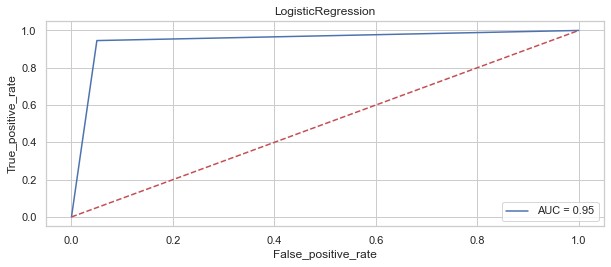

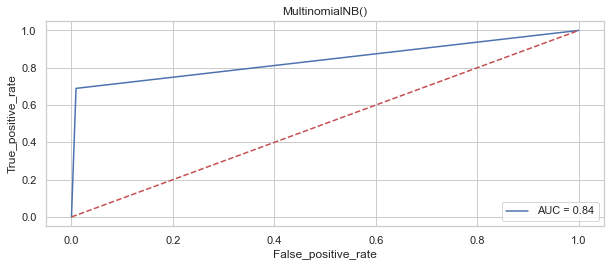

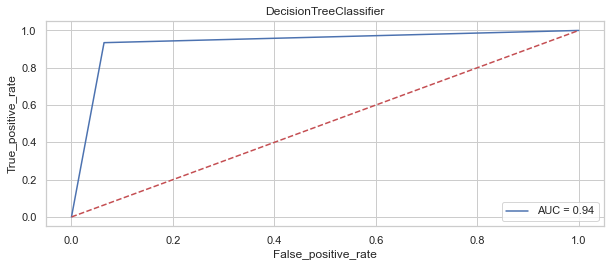

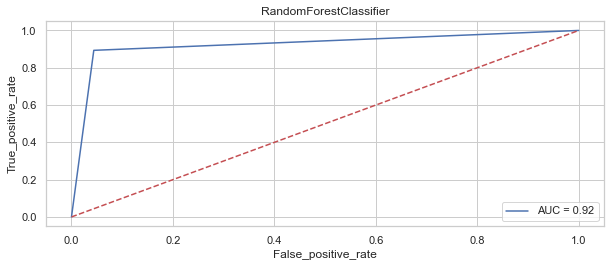

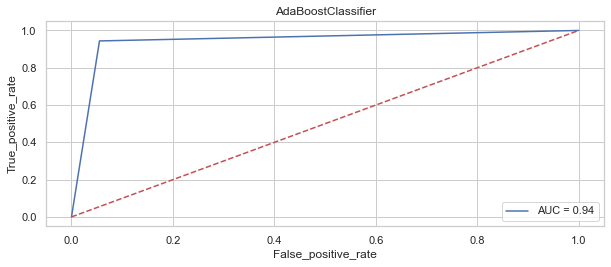

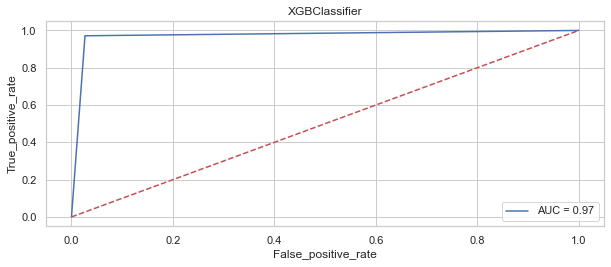

In [52]:
Model=[]
Score=[]
Acc_score=[]
cvs=[]
rocscore=[]
#            For Loop to Calculate Accuracy Score, Cross Val Score, Classification Report, Confusion Matrix

for name,model in models:
    print('***************************',name,'*****************************')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
     #        Now here I am calling a function which will calculate the max accuracy score for each model 
     #                               and return best random state.
    r_state=max_acc_score(model,X,y)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
#..............Learning Score...........
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)
#................Finding Cross_val_score..................    
    cv_score=cross_val_score(model,X,y,cv=10,scoring='roc_auc').mean()
    print('Cross Val Score : ', cv_score)
    cvs.append(cv_score*100)
#................Roc auc score...........................    
    false_positive_rate,true_positive_rate, thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print('roc auc score : ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')
#................Classification Report...........................      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('\n')
    

    
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')
    print('\n\n')

In [53]:
scores=pd.DataFrame({'Model': Model,'Learning Score': Score,'Accuracy Score': Acc_score,'Cross Val Score':cvs,
                     'Roc_Auc_curve':rocscore}) 
scores.style.background_gradient()

,Model,Learning Score,Accuracy Score,Cross Val Score,Roc_Auc_curve
0,LogisticRegression,96.855216,94.782469,98.746218,94.782367
1,MultinomialNB(),88.432425,84.026328,97.430162,84.019065
2,DecisionTreeClassifier,100.000000,93.514208,93.189257,93.514175
3,RandomForestClassifier,100.000000,92.470702,98.224681,92.469192
4,AdaBoostClassifier,94.391687,94.429282,98.466522,94.429258
5,XGBClassifier,99.889898,97.238722,99.543536,97.238675


<AxesSubplot:>

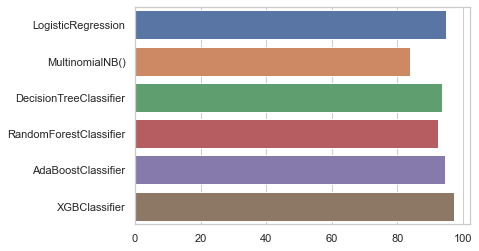

In [54]:
sns.barplot(y=Model,x=Acc_score)

pdf link
https://stackoverflow.com/questions/66097701/how-can-i-fix-this-warning-in-xgboost

In [74]:
# Using XGBClassifier for final model...
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=83,test_size=.30)
XG=XGBClassifier(eval_metric='mlogloss')
XG.fit(x_train,y_train)
XG.score(x_train,y_train)
XGpred=XG.predict(x_test)
print('Accuracy Score:','\n',accuracy_score(y_test,XGpred))
print('Confusion Matrix:',confusion_matrix(y_test,XGpred))
print('Classification Report:','\n',classification_report(y_test,XGpred))

Accuracy Score: 
 0.9680526569272756
Confusion Matrix: [[3011  108]
 [  91 3019]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3119
           1       0.97      0.97      0.97      3110

    accuracy                           0.97      6229
   macro avg       0.97      0.97      0.97      6229
weighted avg       0.97      0.97      0.97      6229



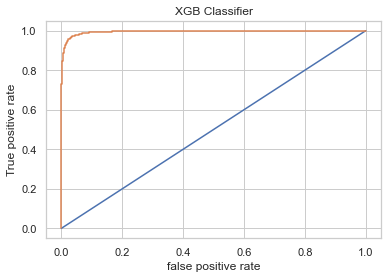

roc_auc_score =  0.995268291325132


In [71]:
# Make predictions with probabilities
y_probs = XG.predict_proba(x_test)

# Keep the probabilites of the positive class only
y_probs = y_probs[:, 1]

# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Check the false positive rate
fpr
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr,label='XGB Classifier')
plt.xlabel('false positive rate')
plt.ylabel('True positive rate')
plt.title('XGB Classifier')
plt.show()
print('roc_auc_score = ',roc_auc_score(y_test, y_probs))


In [72]:
# Printing predicted values
test=pd.DataFrame(data=y_test,)
test['Predicted values']=XGpred
test
# On the lest side values are those which are taken by machine for test...

,label,Predicted values
15556,1,1
11095,0,0
7102,1,1
9496,0,0
7047,0,0
...,...,...
8361,0,0
181,1,1
2106,1,1
14777,1,1
